In [1]:
שלבים בעבודה:
    1. לקרוא את כל קובץ המשימות וללמוד את הרקע טוב
    2. להתמצא בקישורים הנוספים שצורפו
    3. לפתוח את קבצי הטיף בפייתון, להבין מה המבנה שלהם ובכלל באופן בסיסי איך אפשר לעבוד איתם
    4. לחשוב על סוגי מודלים לקלסיפיקציה שאני רוצה להשתמש בהם, חשוב שאני אכיר אותם ואדע למה דווקא הם ואכיר אופציות נוספות שלא בחרתי בהם
    5. הכנת הנתונים לאימון המודל
    6. אימון המודל...
    7. שאלה שנייה: לזהות את הזמן בו נעלם היער, בעצם עבור פוליגון נתון, צריך ליישם את המודל כדי להבין מתי יש ומתי אין בו יער, בשלב הבא לחלץ את התאריך בו קרה השינוי

SyntaxError: invalid syntax (1182963325.py, line 1)

# Import

In [15]:
import os
import rasterio
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Data Loading and Preprocessing

In [2]:
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all non-forest and forest files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")


Loaded 31 non-forest files and 45 forest files.


## Preparing Features and Labels

In [3]:
def prepare_features_and_labels(non_forest_data, forest_data):
    """
    Prepare a feature matrix (X) and a label array (y) from the loaded TIFF data.
    Ensures the number of samples in X and y are consistent.
    """
    feature_list = []
    label_list = []
    
    # Process non-forest data
    for bands in non_forest_data:
        n_samples = bands.shape[1] * bands.shape[2]
        features = bands.reshape(3, n_samples).T  # shape (n_samples, 3)
        feature_list.append(features)
        labels = np.zeros(n_samples)  # Label 0 for non-forest
        label_list.append(labels)
    
    # Process forest data
    for bands in forest_data:
        n_samples = bands.shape[1] * bands.shape[2]
        features = bands.reshape(3, n_samples).T  # shape (n_samples, 3)
        feature_list.append(features)
        labels = np.ones(n_samples)  # Label 1 for forest
        label_list.append(labels)
    
    # Combine all features and labels into single arrays
    X = np.vstack(feature_list)
    y = np.hstack(label_list)
    
    return X, y

# Prepare features and labels
X_row, y_row = prepare_features_and_labels(non_forest_data, forest_data)

# Remove samples with NaN values
mask = ~np.isnan(X_row).any(axis=1)
X = X_row[mask]
y = y_row[mask]

no_nan_data_pct = (y.shape[0]/y_row.shape[0])*100
print(f"Number of data samples after cleaning nans: {y.shape[0]} which are {no_nan_data_pct}% from row data")

print(f"Feature matrix shape: {X.shape}, Labels shape: {y.shape}")


Number of data samples after cleaning nans: 20907341 which are 59.531860045149166% from row data
Feature matrix shape: (20907341, 3), Labels shape: (20907341,)


## Data Splitting: Train, Validation, and Test Sets

In [9]:
# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Now split the temp set into 50% validation, 50% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 14635138 samples
Validation set size: 3136101 samples
Test set size: 3136102 samples


## Train the Model

In [10]:
# Train the model on the training set
rf_classifier.fit(X_train, y_train)

print("Model training on the training set completed.")


Model training on the training set completed.


## Validate the Model 

In [11]:
# Evaluate the model on the validation set
val_predictions = rf_classifier.predict(X_val)
val_accuracy = (val_predictions == y_val).mean()

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9939


## Test the Model

In [21]:
# Evaluate the final model on the test set
test_predictions = rf_classifier.predict(X_test)
test_accuracy = (test_predictions == y_test).mean()

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9938


## Visualization

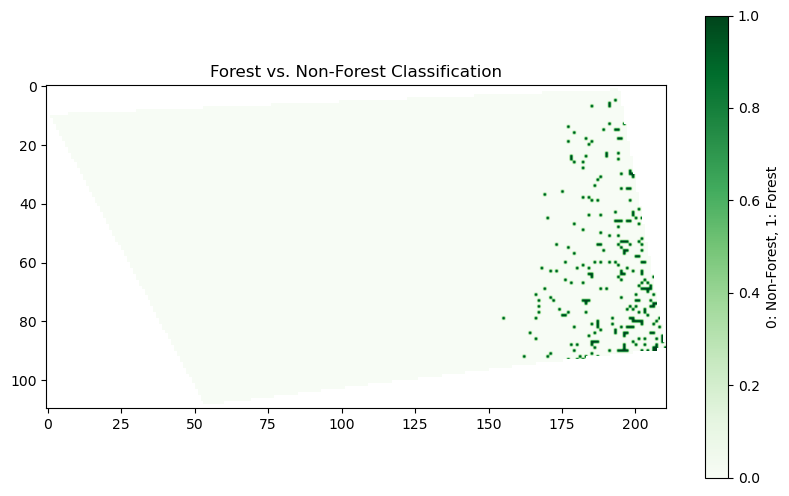

In [20]:
# Example: Preparing a mixed image (e.g., from non-forest or forest dataset) for classification
example_bands = non_forest_data[0]  # Replace with actual image data
n_samples = example_bands.shape[1] * example_bands.shape[2]
example_features = example_bands.reshape(3, n_samples).T  # Flatten the image

# Remove samples (pixels) with NaN values using the mask approach
mask = ~np.isnan(example_features).any(axis=1)
example_features_clean = example_features[mask]

# Predict the forest/non-forest classification for each clean pixel
predictions_clean = rf_classifier.predict(example_features_clean)

# Create an empty array to hold the predictions, initialized with NaNs
forest_mask = np.full(n_samples, np.nan)

# Insert the predictions into the correct positions
forest_mask[mask] = predictions_clean

# Reshape the forest_mask back to the original image dimensions
forest_mask = forest_mask.reshape(example_bands.shape[1], example_bands.shape[2])

# Visualize the classification result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(forest_mask, cmap='Greens')
plt.title("Forest vs. Non-Forest Classification")
plt.colorbar(label="0: Non-Forest, 1: Forest")
plt.show()


## Feature Importance

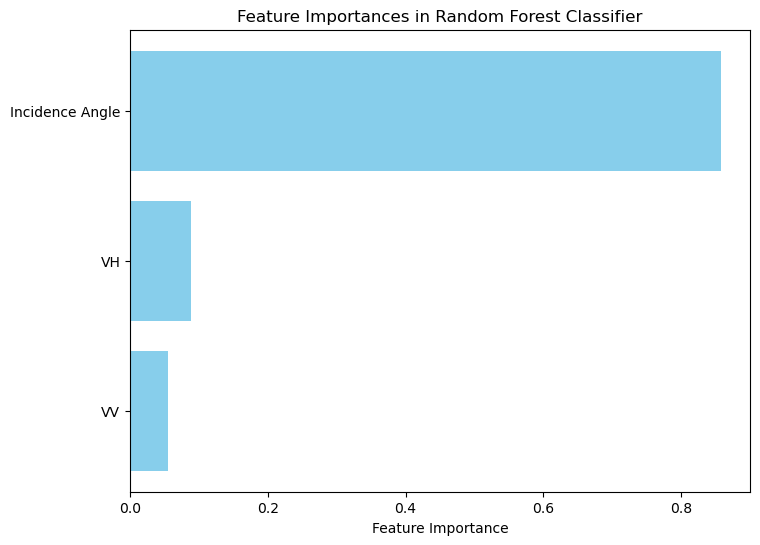

In [18]:
# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = ['VV', 'VH', 'Incidence Angle']

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances in Random Forest Classifier")
plt.show()


## Model Selection and Cross-Validation

In [4]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

In [5]:
cross_val_score(rf_classifier, X, y, cv=3)

print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {np.mean(cv_scores):.4f}")

KeyboardInterrupt: 

## Train the Model on the Entire Dataset

In [6]:
# Train the model on the entire dataset
rf_classifier.fit(X, y)

print("Model training completed.")


Model training completed.


In [7]:
# Example: Predicting forest/non-forest classification for the first non-forest file
example_bands = non_forest_data[0]  # Select the first non-forest image
n_samples = example_bands.shape[1] * example_bands.shape[2]  # Number of pixels
example_features = example_bands.reshape(3, n_samples).T  # Flatten the image

# Predict the forest/non-forest classification for each pixel
predictions = rf_classifier.predict(example_features)
forest_mask = predictions.reshape(example_bands.shape[1], example_bands.shape[2])  # Reshape to image format

print("Prediction completed.")


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## functions

File: D:\Development\RESEARCH\MarvinBlue\Data\non_forest\S1A_IW_GRDH_1SDV_20210806T094017_20210806T094042_039107_049D62_4D8F.tif
 - Dimensions: 211 x 110 pixels
 - Number of bands: 3
 - CRS: EPSG:32720
 - Transform: | 10.00, 0.00, 841550.47|
| 0.00,-10.00, 9327516.55|
| 0.00, 0.00, 1.00|
 - Band 1 min value: nan
 - Band 1 max value: nan


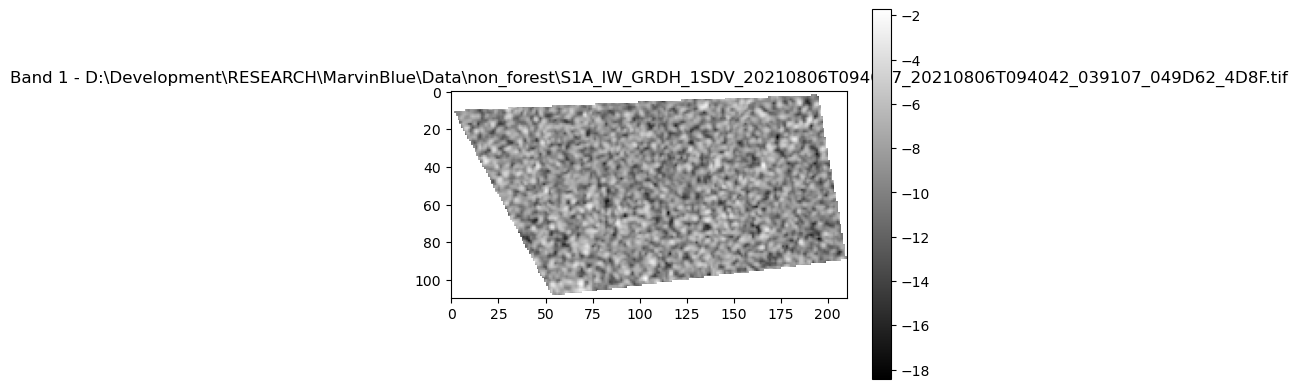

In [5]:
def load_tif_files(directory):
    """
    Load and return a list of file paths from a directory.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    return tif_files

def explore_tif_file(file_path):
    """
    Opens a TIFF file and prints its structure details.
    """
    with rasterio.open(file_path) as src:
        print(f"File: {file_path}")
        print(f" - Dimensions: {src.width} x {src.height} pixels")
        print(f" - Number of bands: {src.count}")
        print(f" - CRS: {src.crs}")
        print(f" - Transform: {src.transform}")
        
        # Load the first band to inspect its contents
        band1 = src.read(1)
        print(f" - Band 1 min value: {band1.min()}")
        print(f" - Band 1 max value: {band1.max()}")
        
        # Display the first band
        plt.imshow(band1, cmap='gray')
        plt.title(f"Band 1 - {file_path}")
        plt.colorbar()
        plt.show()


# Explore the selected TIFF file
explore_tif_file(non_forest_files[0])


In [17]:
file_path = non_forest_files[0]

with rasterio.open(file_path) as src:
    print(f"File: {file_path}")
    print(f" - Dimensions: {src.width} x {src.height} pixels")
    print(f" - Number of bands: {src.count}")
    print(f" - CRS: {src.crs}")
    print(f" - Transform: {src.transform}")
    print(src)
    # Load the first band to inspect its contents
    band1 = src.read(3)
    print(f" - Band 1 min value: {band1}")
    print(f" - Band 1 max value: {band1.max()}")

#     # Display the first band
#     plt.imshow(band1, cmap='gray')
#     plt.title(f"Band 1 - {file_path}")
#     plt.colorbar()
#     plt.show()

File: D:\Development\RESEARCH\MarvinBlue\Data\non_forest\S1A_IW_GRDH_1SDV_20210806T094017_20210806T094042_039107_049D62_4D8F.tif
 - Dimensions: 211 x 110 pixels
 - Number of bands: 3
 - CRS: EPSG:32720
 - Transform: | 10.00, 0.00, 841550.47|
| 0.00,-10.00, 9327516.55|
| 0.00, 0.00, 1.00|
<open DatasetReader name='D:/Development/RESEARCH/MarvinBlue/Data/non_forest/S1A_IW_GRDH_1SDV_20210806T094017_20210806T094042_039107_049D62_4D8F.tif' mode='r'>
 - Band 1 min value: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
 - Band 1 max value: nan


## Load the data

In [3]:
# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load file paths
non_forest_files = load_tif_files(non_forest_dir)
forest_files = load_tif_files(forest_dir)

TypeError: invalid path or file: ['D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20210806T094017_20210806T094042_039107_049D62_4D8F.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20210818T094018_20210818T094043_039282_04A374_8DE2.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20210830T094019_20210830T094044_039457_04A963_7040.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20210923T094020_20210923T094045_039807_04B558_4C5B.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20211005T094020_20211005T094045_039982_04BB7A_D16A.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20211017T094020_20211017T094045_040157_04C186_6CE7.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20211029T094020_20211029T094045_040332_04C799_0533.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20211110T094020_20211110T094045_040507_04CDBA_A781.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20211122T094019_20211122T094044_040682_04D3BD_730F.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20220813T094024_20220813T094049_044532_05508B_0BED.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20220825T094024_20220825T094049_044707_055670_24B3.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20220906T094025_20220906T094050_044882_055C61_3B69.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20220918T094025_20220918T094050_045057_05623E_E959.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20220930T094026_20220930T094051_045232_056819_559A.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221012T094026_20221012T094051_045407_056E01_3857.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221024T094026_20221024T094051_045582_05732D_1C3F.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221105T094026_20221105T094051_045757_057914_D63E.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221117T094025_20221117T094050_045932_057EF9_3B69.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221129T094025_20221129T094050_046107_0584EC_C683.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221211T094025_20221211T094050_046282_058AE5_F4C3.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1A_IW_GRDH_1SDV_20221223T094024_20221223T094049_046457_0590DE_43DD.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20210812T093946_20210812T094011_028211_035D96_BF9A.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20210824T093947_20210824T094012_028386_036315_E7D0.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20210905T093947_20210905T094012_028561_03688C_47C4.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20210917T093948_20210917T094013_028736_036DE9_C58C.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20210929T093948_20210929T094013_028911_03734B_CDA1.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20211011T093948_20211011T094013_029086_037887_F646.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20211023T093948_20211023T094013_029261_037DF3_3CE3.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20211104T093948_20211104T094013_029436_03834E_3353.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20211116T093948_20211116T094013_029611_0388A7_53CD.tif', 'D:\\Development\\RESEARCH\\MarvinBlue\\Data\\non_forest\\S1B_IW_GRDH_1SDV_20211128T093948_20211128T094013_029786_038E28_9431.tif']